<a href="https://colab.research.google.com/github/ballmdr/Forex-Prediction-Machine_Learning/blob/master/Forex_Pytorch_ResNet_%2B_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install fxcmpy

     |████████████████████████████████| 204kB 8.2MB/s 
  Created wheel for socketIO-client: filename=socketIO_client-0.7.2-cp36-none-any.whl size=23707 sha256=8c6af207867a550dd92fb9deb4c83b9ede0c76f1e31b15c07427b459a470e2e4
  Stored in directory: /root/.cache/pip/wheels/bd/5d/9f/ebc0c223ec59641877c817eb10442627e69af88c126f1f53a8
Successfully built socketIO-client


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import fxcmpy
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import skimage as sk
from skimage.transform import resize
import pywt
import pickle
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from google.colab import drive
drive.mount('/content/drive')

def connect():
    return fxcmpy.fxcmpy(access_token=access_token, server=server)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
con = connect()

W0810 13:27:13.294722 140649617688448 fxcmpy.py:222] Default account set to 1041561, to change use set_default_account().


In [0]:
access_token = '8e5f8c5cd314ff9f55c9dd267e212e95140fe0f5'
server = 'demo'
symbol = 'EURUSD'
symbol2 = 'EUR/USD'
timeframe = 'H1'
windows = 20
target_windows = 3
digits = 10000
ratio = 10
n_prices = 10000
K = 3

In [0]:
def getImg(data):
  plt.style.use('dark_background')
  fig = plt.figure(frameon=False) 
  fig.set_size_inches(3,2)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)

  plt.plot(data.ma3, color='red')
  plt.plot(data.ma5, color='blue')
  plt.plot(data.ma8, color='green')
  plt.plot(data.ma10, color='orange')
  plt.plot(data.ma12, color='black')
  plt.plot(data.ma15, color='purple')
  plt.plot(data.ma20, color='lime')
  #plt.plot(_df.open, color='black')
  # plt.plot(_df.close, color='purple')

  plt.savefig('tmp2.png')

  plt.close()

  img = plt.imread('tmp2.png')
  img = resize(img, (100,150))

  return img

In [0]:
def dfProcess(df):
# Short-Term
# ใช้ค่า 3, 5, 8, 10, 12, or 15.
# Long-Term
# ใช้ค่า 30, 35, 40, 45, 50, or 60.
  df['ma3'] = np.round(df.close.rolling(3).mean(), 5)
  df['ma5'] = np.round(df.close.rolling(5).mean(), 5)
  df['ma8'] = np.round(df.close.rolling(8).mean(), 5)
  df['ma10'] = np.round(df.close.rolling(10).mean(), 5)
  df['ma12'] = np.round(df.close.rolling(12).mean(), 5)
  df['ma15'] = np.round(df.close.rolling(15).mean(), 5)
  df['ma20'] = np.round(df.close.rolling(20).mean(), 5)
  #df['ma7_shift3'] = df.ma7.shift(-3)
  #df['ma10_shift3'] = df.ma10.shift(-3)
  #df['close_shift3'] = df.close.shift(-3)
  df['close_diff_pip'] = - df.close.diff(-target_windows) * digits
  
  arr = ['0', '1', '2' ]
  for i in range(1, target_windows):
    df[arr[i]] = - df.close.diff(-i) * digits
    
  df.dropna(inplace=True)

  #df['close_target_percent'] = np.round((df['close_diff_pip']*digits)/df.close, 2) * 100
  #df['7_10_target_percent'] = np.round(((df['ma7_shift3']-df['ma10_shift3'])*digits)/df['ma10_shift3'], 2)
  #df['5_7_target_percent'] = np.round(((df.ma5-df.ma7)*digits)/df.ma7, 2)
  

  df['Target'] = np.ones(len(df))
  # df['Target'].loc[(df['close_target_percent'] > 9) & (df['7_10_target_percent'] > 1) & (df['5_7_target_percent'] > 1)] = 2
  # df['Target'].loc[(df['close_target_percent'] < -9) & (df['7_10_target_percent'] < -1) & (df['5_7_target_percent'] < -1)] = 0
  df['Target'].loc[(df['close_diff_pip'] > ratio) &
                   (df['1'] > -ratio) &
                   (df['2'] > -ratio) 
                  ] = 2
  df['Target'].loc[(df['close_diff_pip'] < -ratio) &
                   (df['1'] < ratio) &
                   (df['2'] < ratio)                
                  ] = 0
  print(df.Target.value_counts())
  
  # df['returns'] = df.close.pct_change(1)
  # df['returns_5'] = df.close.pct_change(5)
  # df['log_return'] = np.log(df.returns)
  # df['log_return_5'] = np.log(df.returns_5)
  
  #df.drop(['bidopen', 'bidclose', 'bidhigh', 'askopen', 'askclose', 'askhigh', 'bidlow', 'asklow', 'tickqty', 'close_diff_pip', '1', '2', '3', '4'], axis=1, inplace=True)
  df.dropna(inplace=True)
  print(df.head())
  print(df.shape)
  
  print(df.info())
  
  return df


def getXY(df, windows):
  print(windows)
  X = []
  Y = []
  for i in range(len(df)-(windows+1)):
    plt.style.use('dark_background')
    fig = plt.figure(frameon=False) 
    fig.set_size_inches(3,2)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    _df = df.iloc[i:windows]
    plt.plot(_df.ma3, color='red')
    plt.plot(_df.ma5, color='blue')
    plt.plot(_df.ma8, color='green')
    plt.plot(_df.ma10, color='orange')
    plt.plot(_df.ma12, color='black')
    plt.plot(_df.ma15, color='purple')
    plt.plot(_df.ma20, color='lime')
    #plt.plot(_df.open, color='black')
   # plt.plot(_df.close, color='purple')

    plt.savefig('tmp2.png')

    plt.close()

    img = plt.imread('tmp2.png')
    new_img = resize(img, (100,150))
    #print(new_img.shape)
    if i % 1000 == 0:
      print(i)
      plt.imshow(new_img)
      plt.show()
      print(i, ' - ', windows)
      print('target: ', df.Target.iloc[windows-1])
    X.append(new_img)
    Y.append(df.Target.iloc[windows-1])

    windows += 1

  return X, Y


In [0]:
def calScore(y_true, y_pred, e, printScore=False):
  #unique, counts = np.unique(np.argmax(y_pred, axis=1), return_counts=True)
  #print(np.asarray((unique, counts)).T)


  y_0 = np.where(y_true == 0.0)
  y_1 = np.where(y_true == 1.0)
  y_2 = np.where(y_true == 2.0)
  # y_3 = np.where(y_test == 3.0)
  # y_4 = np.where(y_test == 4.0)

  pred_0 = []
  pred_1 = []
  pred_2 = []

  for i in y_0[0]:
    pred_0.append(y_pred[i])
  for i in y_1[0]:
    pred_1.append(y_pred[i])
  for i in y_2[0]:
    pred_2.append(y_pred[i])
  # for i in y_3[0]:
  #   x_3.append(x_test[i])
  # for i in y_4[0]:
  #   x_4.append(x_test[i])

  pred_0 = np.array(pred_0)
  pred_1 = np.array(pred_1)
  pred_2 = np.array(pred_2)

  #acc1
  trade_acc0 = len(pred_0[pred_0==0]) + len(pred_0[pred_0==2])
  acc0_win = len(pred_0[pred_0==0])
  acc0_loss = len(pred_0[pred_0==2])

  #acc2
  trade_acc2 = len(pred_2[pred_2==0]) + len(pred_2[pred_2==2])
  acc2_win = len(pred_2[pred_2==2])
  acc2_loss = len(pred_2[pred_2==0])

  #acc1
  trade_acc1 = len(pred_1[pred_1==0]) + len(pred_1[pred_1==2])
  acc1_loss = trade_acc1
  total_trade = trade_acc0 + trade_acc1 + trade_acc2
  
  win_rate = 0.0
  loss_rate = 0.0
  if total_trade > 0:
    win_rate = (acc0_win + acc2_win) / total_trade * 100
    loss_rate = (acc0_loss + acc1_loss + acc2_loss) / total_trade * 100

  rr = 0.0
  if loss_rate > 0:
    rr = win_rate / loss_rate

  if e % 10 == 0 or printScore:
    print("Trade acc0: ", trade_acc0)
    print('acc0 win: ', acc0_win)
    print('acc0 loss: ', acc0_loss)
    print('------')
    print("Trade acc2: ", trade_acc2)
    print('acc2 win: ', acc2_win)
    print('acc2 loss: ', acc2_loss)
    print('------')
    print("Trade acc1: ", trade_acc1)
    print('acc1 loss: ', acc1_loss)
    print('------')
    print("total trade: ", total_trade)
    print('rr: ', rr)
    print('win rate: ', np.round(win_rate, 2))
    print('loss rate:', np.round(loss_rate, 2))
    print('pred_0 max: ', pred_0.max())
    print('pred_2 min: ', pred_2.min())

  return rr, pred_0, pred_2

In [6]:
df = con.get_candles(symbol2, period=timeframe, number=n_prices)
df['close'] = (df.bidclose + df.askclose) / 2
df = dfProcess(df)

#df['close'] = (df.close - df.close.mean()) / (df.close.max() - df.close.min())
#print(df['close'].head())
#df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]



# pca = PCA(n_components=.90)
# train_data = pca.fit_transform(train_data)
# test_data = pca.transform(test_data)

# scale = StandardScaler()
# minmax = MinMaxScaler()
# train_data = minmax.fit_transform(train_data)
# test_data = minmax.transform(test_data)


1.0    6113
0.0    1959
2.0    1906
Name: Target, dtype: int64
                     bidopen  bidclose  bidhigh  ...      1      2  Target
date                                             ...                      
2018-01-12 13:00:00  1.21327   1.21193  1.21484  ...  17.85  28.15     2.0
2018-01-12 14:00:00  1.21193   1.21374  1.21483  ...  10.30  -7.60     1.0
2018-01-12 15:00:00  1.21374   1.21475  1.21547  ... -17.90 -13.60     1.0
2018-01-12 16:00:00  1.21475   1.21296  1.21552  ...   4.30  32.05     2.0
2018-01-12 17:00:00  1.21296   1.21339  1.21366  ...  27.75  46.75     2.0

[5 rows x 21 columns]
(9978, 21)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9978 entries, 2018-01-12 13:00:00 to 2019-08-09 17:00:00
Data columns (total 21 columns):
bidopen           9978 non-null float64
bidclose          9978 non-null float64
bidhigh           9978 non-null float64
bidlow            9978 non-null float64
askopen           9978 non-null float64
askclose          9978 non-null flo

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
split = int(len(df) * 0.60)
train_data = df.iloc[:split]
test_data = df.iloc[split:]

# x_train, y_train = getXY(train_data, windows)
# x_test, y_test = getXY(test_data, windows)

In [5]:
with open('/content/drive/My Drive/Colab Notebooks/x_train_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'wb') as file:
  pickle.dump(x_train, file)
with open('/content/drive/My Drive/Colab Notebooks/y_train_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'wb') as file:
  pickle.dump(y_train, file)
with open('/content/drive/My Drive/Colab Notebooks/x_test_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'wb') as file:
  pickle.dump(x_test, file)
with open('/content/drive/My Drive/Colab Notebooks/y_test_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'wb') as file:
  pickle.dump(y_test, file)

NameError: ignored

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/x_train_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'rb') as file:
  x_train = pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/y_train_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'rb') as file:
  y_train = pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/x_test_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'rb') as file:
  x_test = pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/y_test_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'rb') as file:
  y_test = pickle.load(file)

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/pca.pickle', 'wb') as file:
  pickle.dump(pca, file)
with open('/content/drive/My Drive/Colab Notebooks/scale.pickle', 'wb') as file:
  pickle.dump(scale, file)
with open('/content/drive/My Drive/Colab Notebooks/x_train_pca.pickle', 'wb') as file:
  pickle.dump(new_test_img, file)
with open('/content/drive/My Drive/Colab Notebooks/x_test_pca.pickle', 'wb') as file:
  pickle.dump(x_test_pca, file)

In [6]:
# load pca sample

with open('/content/drive/My Drive/Colab Notebooks/x_train_pca.pickle', 'rb') as file:
  x_train_pca = pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/x_test_pca.pickle', 'rb') as file:
  x_test_pca = pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/y_train_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'rb') as file:
  y_train = pickle.load(file) 
with open('/content/drive/My Drive/Colab Notebooks/y_test_' + symbol + '_' + timeframe + '_' + str(n_prices) + '.pickle', 'rb') as file:
  y_test = pickle.load(file)

FileNotFoundError: ignored

In [0]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

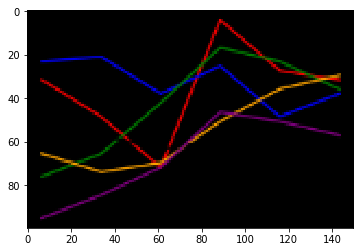

In [0]:
idx = np.random.randint(0, len(x_test)-1)
plt.imshow(x_test[idx])
plt.show()

In [0]:
x_test[0]

array([[[0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        ...,
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157]],

       [[0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        ...,
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157]],

       [[0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.        , 0.        , 0.00392157],
        ...,
        [0.        , 0.        , 0.        , 0.00392157],
        [0.        , 0.      

In [0]:
x_train /= 255
x_test /= 255

In [0]:
def init_weights(m):
    if isinstance(m, nn.Linear):
      size = m.weight.size()
      fan_out = size[0] # number of rows
      fan_in = size[1] # number of columns
      variance = np.sqrt(2.0/(fan_in))
      m.weight.data.normal_(0.0, variance)
      if m.bias is not None:
        m.bias.data.fill_(0)
        
    elif isinstance(m, nn.Conv3d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, (2. / n)**.5)
    elif isinstance(m, nn.BatchNorm3d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
        
    # elif isinstance(m, nn.Conv2d):
    #   size = m.weight.size()
    #   fan_out = size[0] # number of rows
    #   fan_in = size[1] # number of columns
    #   variance = np.sqrt(2.0/(fan_in))
    #   m.weight.data.normal_(0.0, variance)
    #   if m.bias is not None:
    #     m.bias.data.fill_(0)

#     if isinstance(m, nn.Conv2d):
#         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0)
#     elif isinstance(m, nn.BatchNorm2d):
#         nn.init.constant_(m.weight, 1)
#         nn.init.constant_(m.bias, 0)
#     elif isinstance(m, nn.Linear):
#         nn.init.normal_(m.weight, 0, 0.01)
#         if m.bias is not None:
#             nn.init.constant_(m.bias, 0)

                   

        
        
#     if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
#         import scipy.stats as stats
#         X = stats.truncnorm(-2, 2, scale=0.01)
#         values = torch.as_tensor(X.rvs(m.weight.numel()), dtype=m.weight.dtype)
#         values = values.view(m.weight.size())
#         with torch.no_grad():
#             m.weight.copy_(values)
#     elif isinstance(m, nn.BatchNorm2d):
#         nn.init.constant_(m.weight, 1)
#         nn.init.constant_(m.bias, 0)

In [0]:
class LSTM(nn.Module):
  def __init__(self, hidden, output_size, input_size, n_layers):
    super(LSTM, self).__init__()
    self.n_layers = n_layers
    
    self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden, num_layers=n_layers, batch_first=True)
    self.linear1 = nn.Linear(hidden, hidden, bias=False)
    self.bn1 = nn.BatchNorm2d(hidden)
    self.linear2 = nn.Linear(hidden, output_size, bias=False)
    self.bn2 = nn.BatchNorm2d(hidden)
    self.relu = nn.ReLU(inplace=True)
    self.drop = nn.Dropout(p=0.5, inplace=True)
    self.softmax = nn.LogSoftmax(dim=1)
    
  def forward(self, x, h, c):
    logit, (h, c) = self.lstm1(x, (h, c))
    logit = self.linear1(logit)
    logit = self.bn1(logit)
    logit = self.relu(logit)
    logit = self.drop(logit)
    logit = self.bn2(self.linear2(logit))

    pred = self.softmax(logit)
    return logit, pred

In [0]:
batch_size = 32
sequence = 10
width = 100
height = 150
channel = 4
hidden = 1024
N = len(train_data) - (windows * sequence)
input_size = 2326
K = 3
n_layers = 5
model = LSTM(hidden, K, input_size, n_layers)
model.cuda()
model.apply(init_weights)

epochs = 10000

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
train_loss = []
test_loss = []
for e in range(epochs):
  model.train()
  optimizer.zero_grad()
  x_batch = np.zeros((batch_size, sequence, input_size))
  y_batch = np.zeros((batch_size))
  for b in range(batch_size):
    x = np.zeros((sequence, input_size))
    y = np.zeros((sequence))
    index = np.random.randint(0, N)
    #print(index)
    for s in range(sequence):
      #start = index
      #end = start + windows
      #print(start, ':', end)
      #img = getImg(train_data.iloc[start:end])
      #plt.imshow(img)
      #plt.show()
      #img = img.reshape(1, -1)
      #img = scale.transform(img)
      #img = pca.transform(img)
      img = new_test_img[index]
      #img = img.reshape(1, -1)
      #print(img.shape)

      x[s] = img
      y[s] = y_train[index]
      index += 1
    x_batch[b] = x
    y_batch[b] = y[-1]

  x_batch = torch.FloatTensor(x_batch).cuda()
  y_batch = torch.LongTensor(y_batch).cuda()
  h0 = torch.zeros((n_layers, batch_size, hidden), dtype=torch.float32).cuda()
  c0 = torch.zeros((n_layers, batch_size, hidden), dtype=torch.float32).cuda()
  logit, pred = model(x_batch, h0, c0)
  #print(logit[0,-1])
  loss = loss_fn(logit[:,-1], y_batch)

  train_loss.append(loss.item())

  loss.backward()
  optimizer.step()

  model.eval()
  test_count = 100
  avg_loss = 0.0

  for i in range(test_count):
    x_batch_test = np.zeros((1, sequence, input_size))
    y_batch_test = np.zeros((1))
    index = np.random.randint(0, len(x_test_pca)-(windows * sequence))
    x_t = np.zeros((sequence, input_size))
    y_t = np.zeros((sequence))
    for s in range(sequence):
      x_t[s] = x_test_pca[index]
      y_t[s] = y_test[index]
      index += 1
    #print(x.shape)
    x_batch_test[0] = x_t
    y_batch_test[0] = y_t[-1]
    x_batch_test = torch.FloatTensor(x_batch_test).cuda()
    y_batch_test = torch.LongTensor(y_batch_test).cuda()

    h0 = torch.zeros((n_layers, 1, hidden), dtype=torch.float32).cuda()
    c0 = torch.zeros((n_layers, 1, hidden), dtype=torch.float32).cuda()
    logit, pred = model(x_batch_test, h0, c0)    
    loss = loss_fn(logit[:,-1], y_batch_test)
    avg_loss += loss.item() / test_count

  test_loss.append(avg_loss)
  scheduler.step(avg_loss)
  if e % 10 == 0:
    print(e, ' train: ', loss.item(), ' test: ', avg_loss)



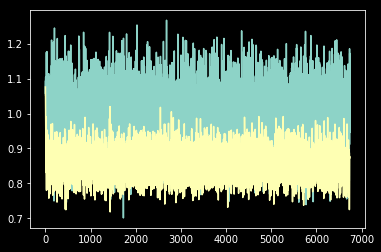

In [72]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.show()

In [25]:
y_train.shape

(5982,)

In [0]:
x_batch.shape

tensor([ 3.4320, 10.1946,  1.5761], device='cuda:0', grad_fn=<SliceBackward>)

In [47]:
print(h0.shape)
print(x_batch.shape)
print(y_batch.shape)
print(logit.shape)

torch.Size([1, 1, 128])
torch.Size([1, 5, 2326])
torch.Size([1])
torch.Size([1, 5, 3])


In [0]:
test_img = getImg(train_data.iloc[start:end])
test_img.shape

(100, 150, 4)

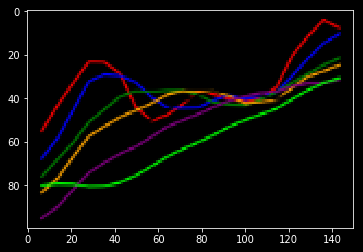

In [0]:
plt.imshow(test_img)

In [0]:
test_img = test_img.reshape(1, -1)

In [218]:
x_train.shape

(5982, 100, 150, 4)

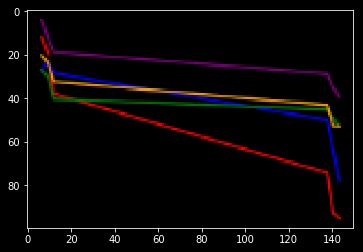

In [217]:
plt.imshow(x_train[0])

In [224]:
test_img.shape

(1, 60000)

In [13]:
scale = StandardScaler()
pca = PCA(n_components=.99)

x_train_scale = scale.fit_transform(x_train.reshape(len(x_train), -1))=
x_train_pca = pca.fit_transform(x_train_scale)

x_test_scale = scale.transform(x_test.reshape(len(x_test), -1))
x_test_pca = pca.transform(x_test_scale)

W0810 09:23:26.378623 139758004795136 logs.py:14] api.fxcm.com:443/socket.io [connection error] recv disconnected ([Errno 32] Broken pipe)


(5982, 2326)


ValueError: ignored

In [36]:
x_test_pca.shape

(3987, 2326)

In [37]:
y_test.shape

(3987,)

In [0]:
with open('/content/drive/My Drive/Colab Notebooks/pca.pickle', 'wb') as file:
  pickle.dump(pca, file)
with open('/content/drive/My Drive/Colab Notebooks/scale.pickle', 'wb') as file:
  pickle.dump(scale, file)
with open('/content/drive/My Drive/Colab Notebooks/x_train_pca.pickle', 'wb') as file:
  pickle.dump(new_test_img, file)
with open('/content/drive/My Drive/Colab Notebooks/x_test_pca.pickle', 'wb') as file:
  pickle.dump(x_test_pca, file)

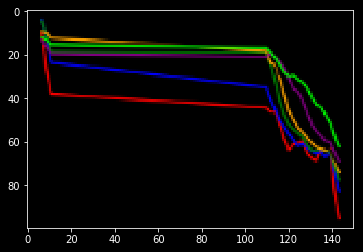

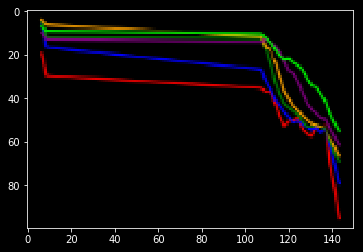

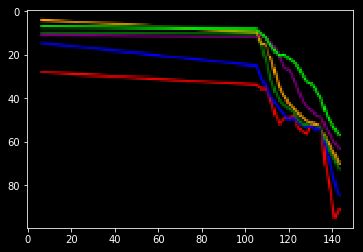

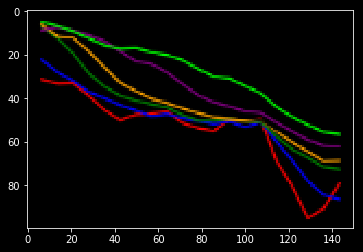

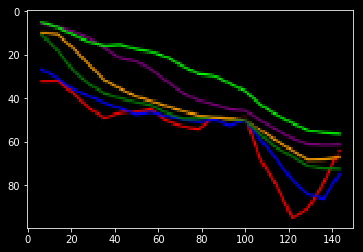

In [0]:
  plt.imshow(x_batch[3][i])
  plt.show()